In [131]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import undetected_chromedriver as uc

import time
import pandas as pd

In [22]:
############################################################################

driver = uc.Chrome()

###########################################################################


driver.get("https://app.prizepicks.com/")
time.sleep(3)

WebDriverWait(driver, 15).until(EC.presence_of_all_elements_located((By.CLASS_NAME, "close")))
time.sleep(3)
driver.find_element(By.CLASS_NAME, "close").click()
time.sleep(3)

ppPlayers = []

# CHANGE MLB TO ANY SPORT THAT YOU LIKE!!!!! IF THE SPORT IS NOT OFFERED ON PP THEN THE PROGRAM WILL RUN AN ERROR AND EXIT.
driver.find_element(By.XPATH, "//div[@class='name'][normalize-space()='MLBSZN']").click()
time.sleep(5)

stat_container = WebDriverWait(driver, 1).until(EC.visibility_of_element_located((By.CLASS_NAME, "stat-container")))

categories = driver.find_element(By.CSS_SELECTOR, ".stat-container").text.split('\n')

for category in categories:
    driver.find_element(By.XPATH, f"//div[text()='{category}']").click()

    projectionsPP = WebDriverWait(driver, 5).until(
        EC.presence_of_all_elements_located((By.CSS_SELECTOR, ".projection")))

    for projections in projectionsPP:
        names = projections.find_element(By.CLASS_NAME, "name").text
        value = projections.find_element(By.CLASS_NAME, "presale-score").get_attribute('innerHTML')
        proptype = projections.find_element(By.CLASS_NAME, "text").get_attribute('innerHTML')

        players = {
            'Name': names,
            'Value': value,
            'Prop': proptype.replace("<wbr>", "")
        }
        ppPlayers.append(players)

dfProps = pd.DataFrame(ppPlayers)
# CHANGE THE NAME OF THE FILE TO YOUR LIKING
dfProps.to_csv('test2.csv')

print("These are all of the props offered by PP.", '\n')
print(dfProps)
print('\n')

These are all of the props offered by PP. 

                 Name  Value       Prop
0       Shohei Ohtani   38.5  Home Runs
1           Juan Soto   35.5  Home Runs
2         Aaron Judge   44.5  Home Runs
3    Ronald Acuña Jr.   37.5  Home Runs
4      Yordan Alvarez   37.5  Home Runs
..                ...    ...        ...
103       Pete Alonso  108.5       RBIs
104     Rafael Devers  101.5       RBIs
105  Ronald Acuña Jr.   99.5       RBIs
106     Shohei Ohtani  105.5       RBIs
107    Yordan Alvarez  109.5       RBIs

[108 rows x 3 columns]




In [77]:
dfProps.Prop.unique()
bat_props = dfProps[dfProps['Prop'].isin(['Home Runs', 'Stolen Bases', 'Hits', 'RBIs'])]
pitch_props = dfProps[~dfProps['Prop'].isin(['Home Runs', 'Stolen Bases', 'Hits', 'RBIs'])]

bat_props = bat_props.copy()
bat_props['Name'] = bat_props['Name'].replace({'Julio Rodriguez': 'Julio Rodríguez',
                                               'Jose Ramirez':'José Ramírez',
                                               'Franciso Lindor':'Francisco Lindor', 
                                               'Jazz Chisholm':'Jazz Chisholm Jr.',
                                               'Luis Robert':'Luis Robert Jr.'}, regex=True)
bat_props = bat_props.pivot(index='Name', columns='Prop', values='Value')

pitch_props = pitch_props.copy()
pitch_props['Name'] = pitch_props['Name'].replace({'Jesus Luzardo': 'Jesús Luzardo',
                                                   'Pablo Lopez': 'Pablo López'}, regex=True)
pitch_props = pitch_props.pivot(index='Name', columns='Prop', values='Value')


In [132]:
patc = pd.read_csv('atc.csv')
batc = pd.read_csv('batc_2024.csv')

In [133]:
bat = pd.merge(bat_props, batc, left_on='Name', right_on='Name', how='left')
pitch = pd.merge(pitch_props, patc, left_on='Name', right_on='Name', how='left')


In [143]:
batc.loc[batc['Name'] == 'Esteury Ruiz', 'SB']

177    54.1783
Name: SB, dtype: float64

In [151]:
bat_2 = bat[['Name', 'Team', 'Home Runs', 'Stolen Bases', 'Hits', 'RBIs', 'HR', 'SB', 'H', 'RBI']]
bat_2 = bat_2.copy()
bat_2['Home Runs'] = bat_2['Home Runs'].astype('float')
bat_2['Stolen Bases'] = bat_2['Stolen Bases'].astype('float')
bat_2['Hits'] = bat_2['Hits'].astype('float')
bat_2['RBIs'] = bat_2['RBIs'].astype('float')

bat_2['HR_diff'] = bat_2['HR'] - bat_2['Home Runs']
bat_2['SB_diff'] = bat_2['SB'] - bat_2['Stolen Bases']
bat_2['H_diff'] = bat_2['H'] - bat_2['Hits']
bat_2['RBI_diff'] = bat_2['RBI'] - bat_2['RBIs']
bat_2['Shortened_Name'] = bat_2['Name'].str.split().apply(lambda x: f"{x[0][0]}. {' '.join(x[1:])}")

pitch_2 = pitch[['Name', 'Team', 'Strikeouts', 'SO']]
pitch_2 = pitch_2.copy()
pitch_2['Strikeouts'] = pitch_2['Strikeouts'].astype('float')
pitch_2['SO_diff'] = pitch_2['SO'] - pitch_2['Strikeouts']
pitch_2['Shortened_Name'] = pitch_2['Name'].str.split().apply(lambda x: f"{x[0][0]}. {' '.join(x[1:])}")


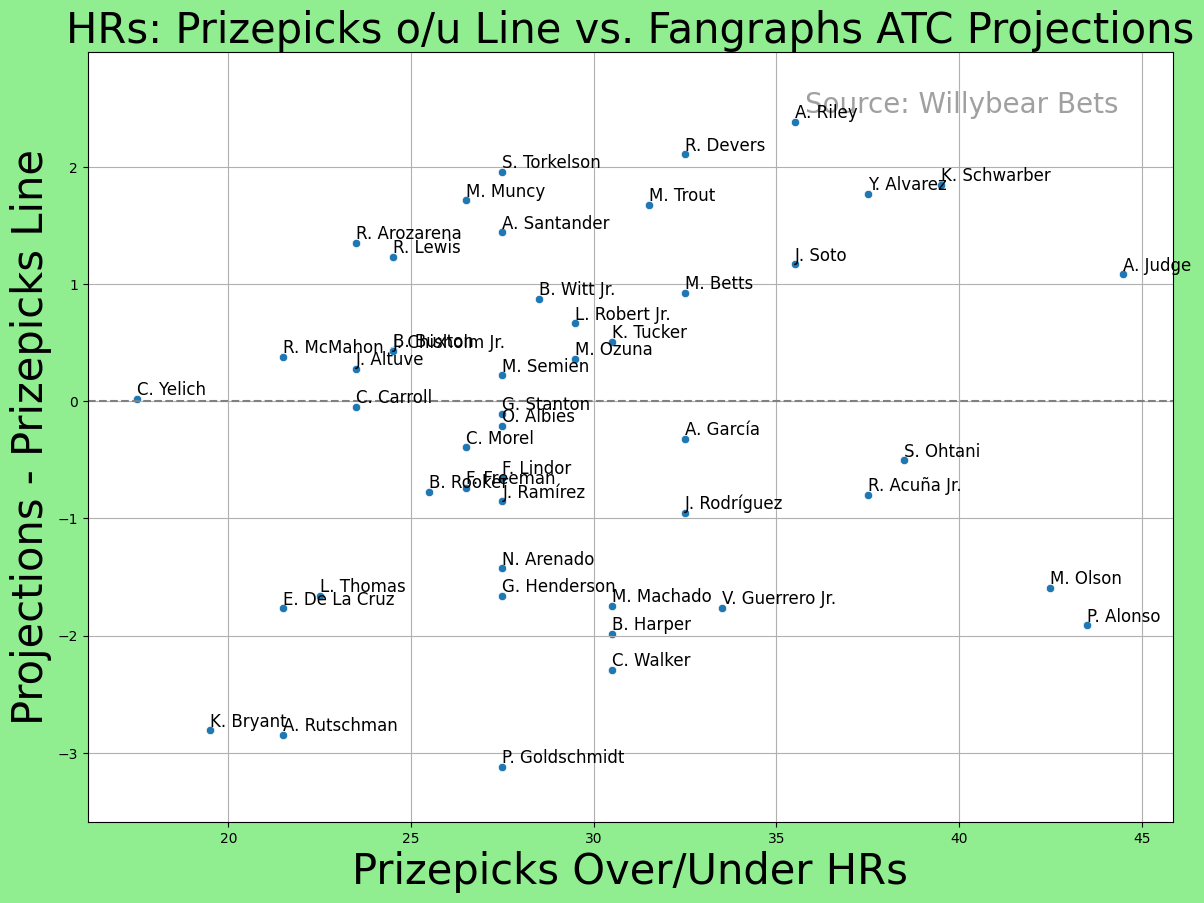

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns
stat = 'HR'
stat_col = "HR_diff"
stat_col_proj = "Home Runs"
bat_2_filtered = bat_2.dropna(subset=[stat_col, stat_col_proj])
# Adjusting the plot to be horizontal for better visualization of differentials
plt.figure(figsize=(14, 10), facecolor='lightgreen')
sns.scatterplot(data=bat_2_filtered, y=stat_col, x=stat_col_proj)
plt.title(f"{stat}s: Prizepicks o/u Line vs. Fangraphs ATC Projections", fontsize = 30)
plt.ylabel("Projections - Prizepicks Line", fontsize = 30)
plt.xlabel(f"Prizepicks Over/Under {stat}s", fontsize = 30)
plt.ylim(min(bat_2_filtered[stat_col]) + (min(bat_2_filtered[stat_col]) * .15), max(bat_2_filtered[stat_col]) + (max(bat_2_filtered[stat_col]) * .25))
plt.axhline(0, color='grey', ls='--')  # Adding a horizontal reference line at y=0
plt.grid(True)
plt.text(0.95, 0.95, "Source: Willybear Bets", transform=plt.gca().transAxes,
         ha='right', va='top', fontsize=20, color='gray', alpha=0.75)

for index, row in bat_2_filtered.iterrows():
    # Convert to float before adding the offset
    x_position = (row[stat_col_proj])
    y_position = (row[stat_col])
    plt.text(x_position, y_position, row['Shortened_Name'], verticalalignment='bottom', size='large', color='black')

plt.show()


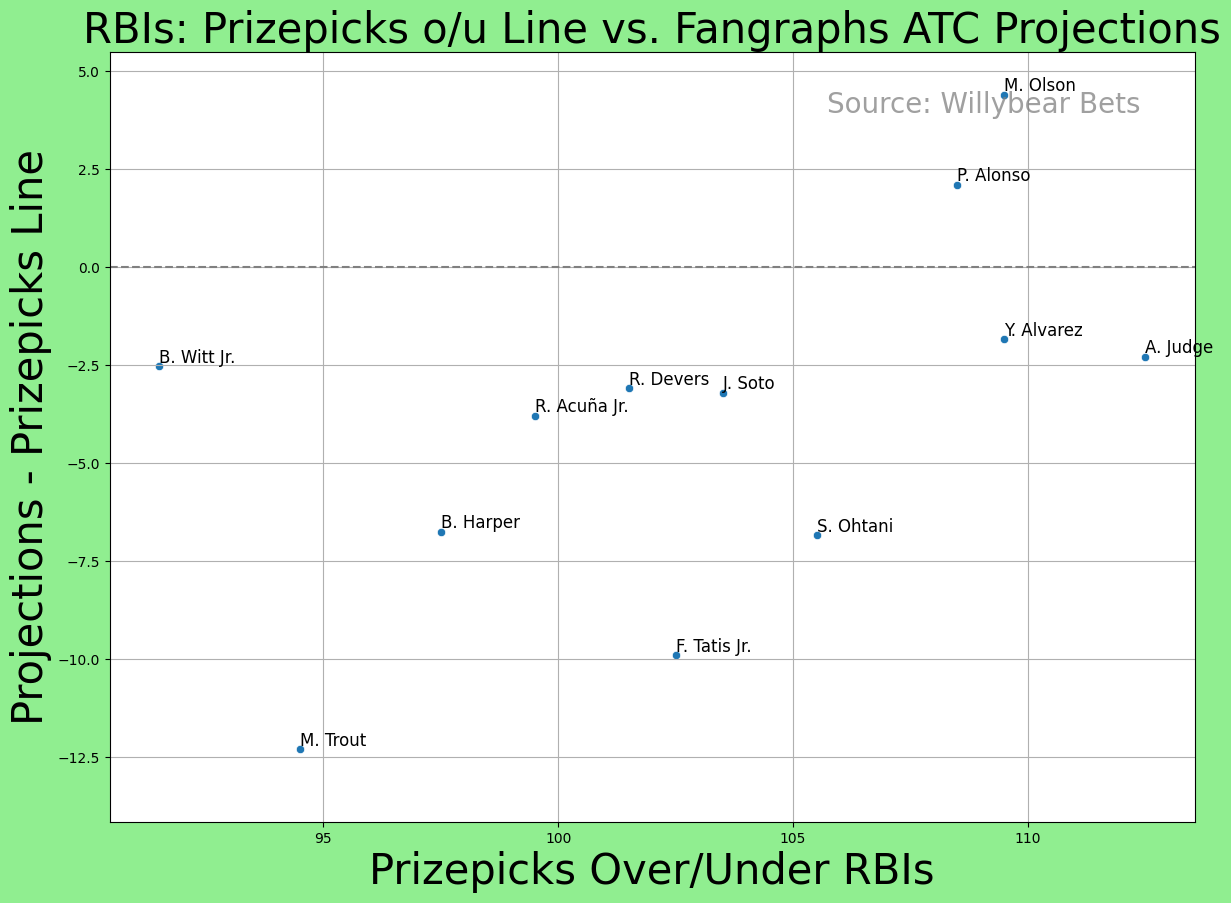

In [137]:
stat = 'RBI'
stat_col = "RBI_diff"
stat_col_proj = "RBIs"

bat_2_filtered = bat_2.dropna(subset=[stat_col, stat_col_proj])
# Adjusting the plot to be horizontal for better visualization of differentials
plt.figure(figsize=(14, 10), facecolor='lightgreen')
sns.scatterplot(data=bat_2_filtered, y=stat_col, x=stat_col_proj)
plt.title(f"{stat}s: Prizepicks o/u Line vs. Fangraphs ATC Projections", fontsize = 30)
plt.ylabel("Projections - Prizepicks Line", fontsize = 30)
plt.xlabel(f"Prizepicks Over/Under {stat}s", fontsize = 30)
plt.ylim(min(bat_2_filtered[stat_col]) + (min(bat_2_filtered[stat_col]) * .15), max(bat_2_filtered[stat_col]) + (max(bat_2_filtered[stat_col]) * .25))
plt.axhline(0, color='grey', ls='--')  # Adding a horizontal reference line at y=0
plt.grid(True)
plt.text(0.95, 0.95, "Source: Willybear Bets", transform=plt.gca().transAxes,
         ha='right', va='top', fontsize=20, color='gray', alpha=0.75)

for index, row in bat_2_filtered.iterrows():
    # Convert to float before adding the offset
    x_position = (row[stat_col_proj])
    y_position = (row[stat_col])
    plt.text(x_position, y_position, row['Shortened_Name'], verticalalignment='bottom', size='large', color='black')

plt.show()

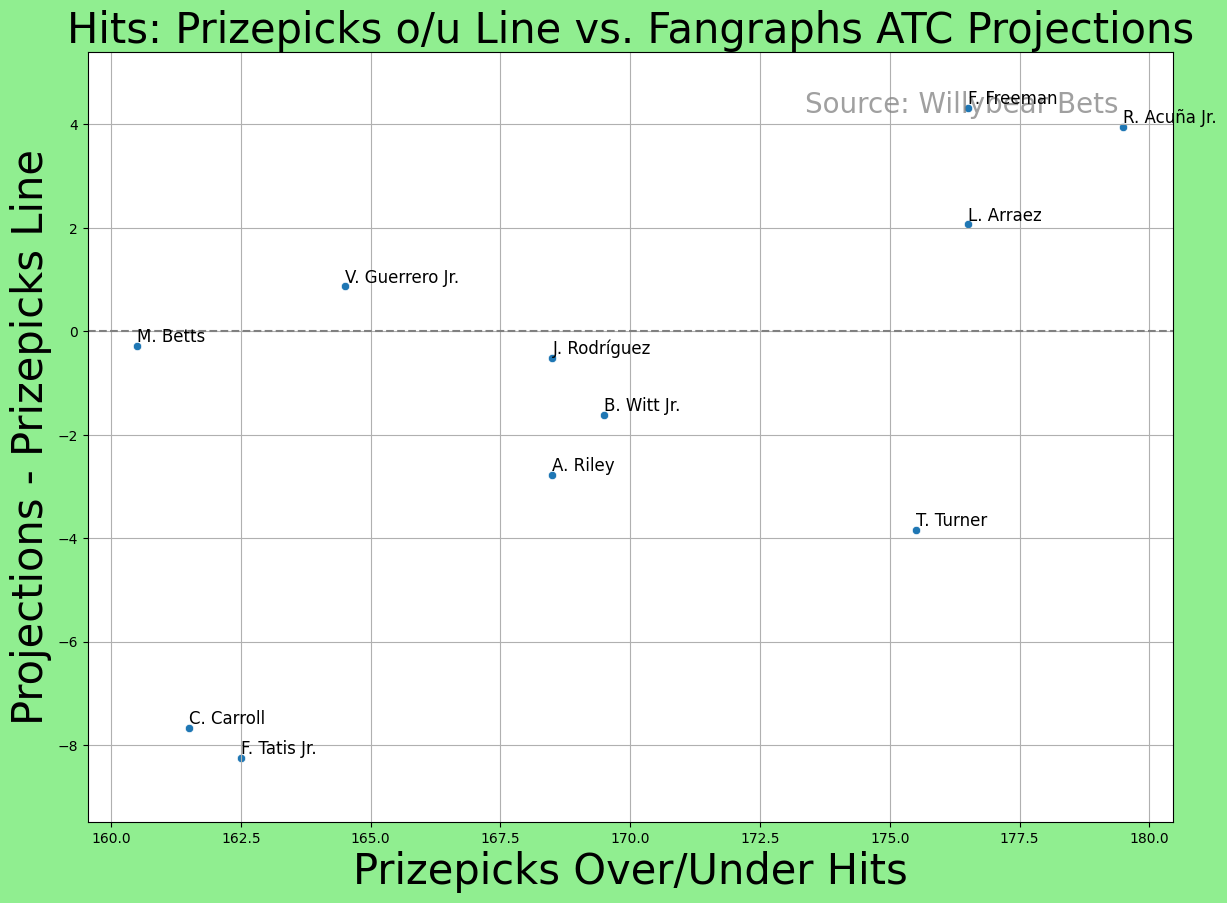

In [138]:
stat = 'Hit'
stat_col = "H_diff"
stat_col_proj = "Hits"
bat_2_filtered = bat_2.dropna(subset=[stat_col, stat_col_proj])
# Adjusting the plot to be horizontal for better visualization of differentials
plt.figure(figsize=(14, 10), facecolor='lightgreen')
sns.scatterplot(data=bat_2_filtered, y=stat_col, x=stat_col_proj)
plt.title(f"{stat}s: Prizepicks o/u Line vs. Fangraphs ATC Projections", fontsize = 30)
plt.ylabel("Projections - Prizepicks Line", fontsize = 30)
plt.xlabel(f"Prizepicks Over/Under {stat}s", fontsize = 30)
plt.ylim(min(bat_2_filtered[stat_col]) + (min(bat_2_filtered[stat_col]) * .15), max(bat_2_filtered[stat_col]) + (max(bat_2_filtered[stat_col]) * .25))
plt.axhline(0, color='grey', ls='--')  # Adding a horizontal reference line at y=0
plt.grid(True)
plt.text(0.95, 0.95, "Source: Willybear Bets", transform=plt.gca().transAxes,
         ha='right', va='top', fontsize=20, color='gray', alpha=0.75)

for index, row in bat_2_filtered.iterrows():
    # Convert to float before adding the offset
    x_position = (row[stat_col_proj])
    y_position = (row[stat_col])
    plt.text(x_position, y_position, row['Shortened_Name'], verticalalignment='bottom', size='large', color='black')

plt.show()

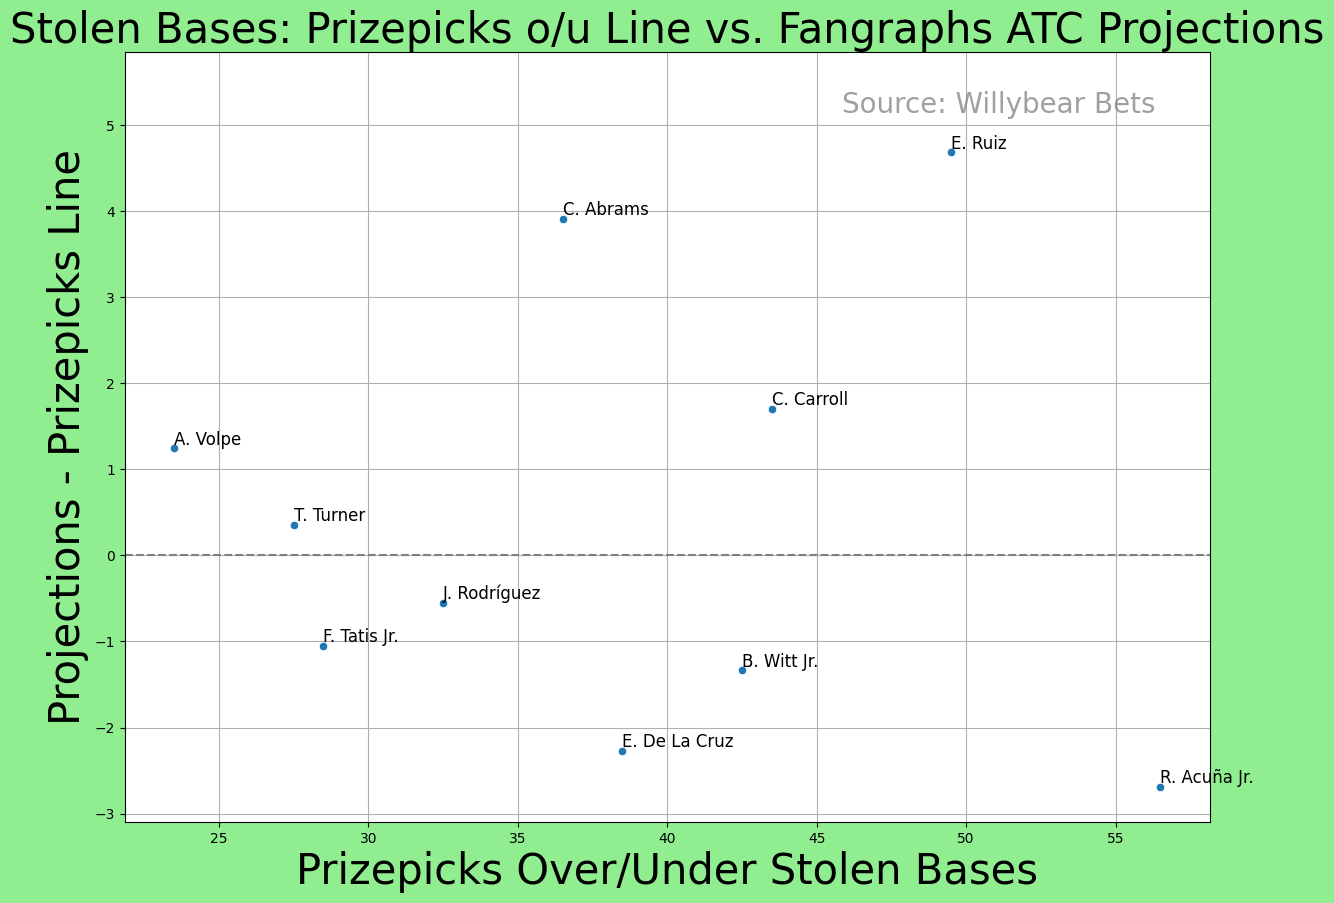

In [139]:
stat = 'Stolen Base'
stat_col = "SB_diff"
stat_col_proj = "Stolen Bases"
bat_2_filtered = bat_2.dropna(subset=[stat_col, stat_col_proj])
# Adjusting the plot to be horizontal for better visualization of differentials
plt.figure(figsize=(14, 10), facecolor='lightgreen')
sns.scatterplot(data=bat_2_filtered, y=stat_col, x=stat_col_proj)
plt.title(f"{stat}s: Prizepicks o/u Line vs. Fangraphs ATC Projections", fontsize = 30)
plt.ylabel("Projections - Prizepicks Line", fontsize = 30)
plt.xlabel(f"Prizepicks Over/Under {stat}s", fontsize = 30)
plt.ylim(min(bat_2_filtered[stat_col]) + (min(bat_2_filtered[stat_col]) * .15), max(bat_2_filtered[stat_col]) + (max(bat_2_filtered[stat_col]) * .25))
plt.axhline(0, color='grey', ls='--')  # Adding a horizontal reference line at y=0
plt.grid(True)
plt.text(0.95, 0.95, "Source: Willybear Bets", transform=plt.gca().transAxes,
         ha='right', va='top', fontsize=20, color='gray', alpha=0.75)

for index, row in bat_2_filtered.iterrows():
    # Convert to float before adding the offset
    x_position = (row[stat_col_proj])
    y_position = (row[stat_col])
    plt.text(x_position, y_position, row['Shortened_Name'], verticalalignment='bottom', size='large', color='black')

plt.show()

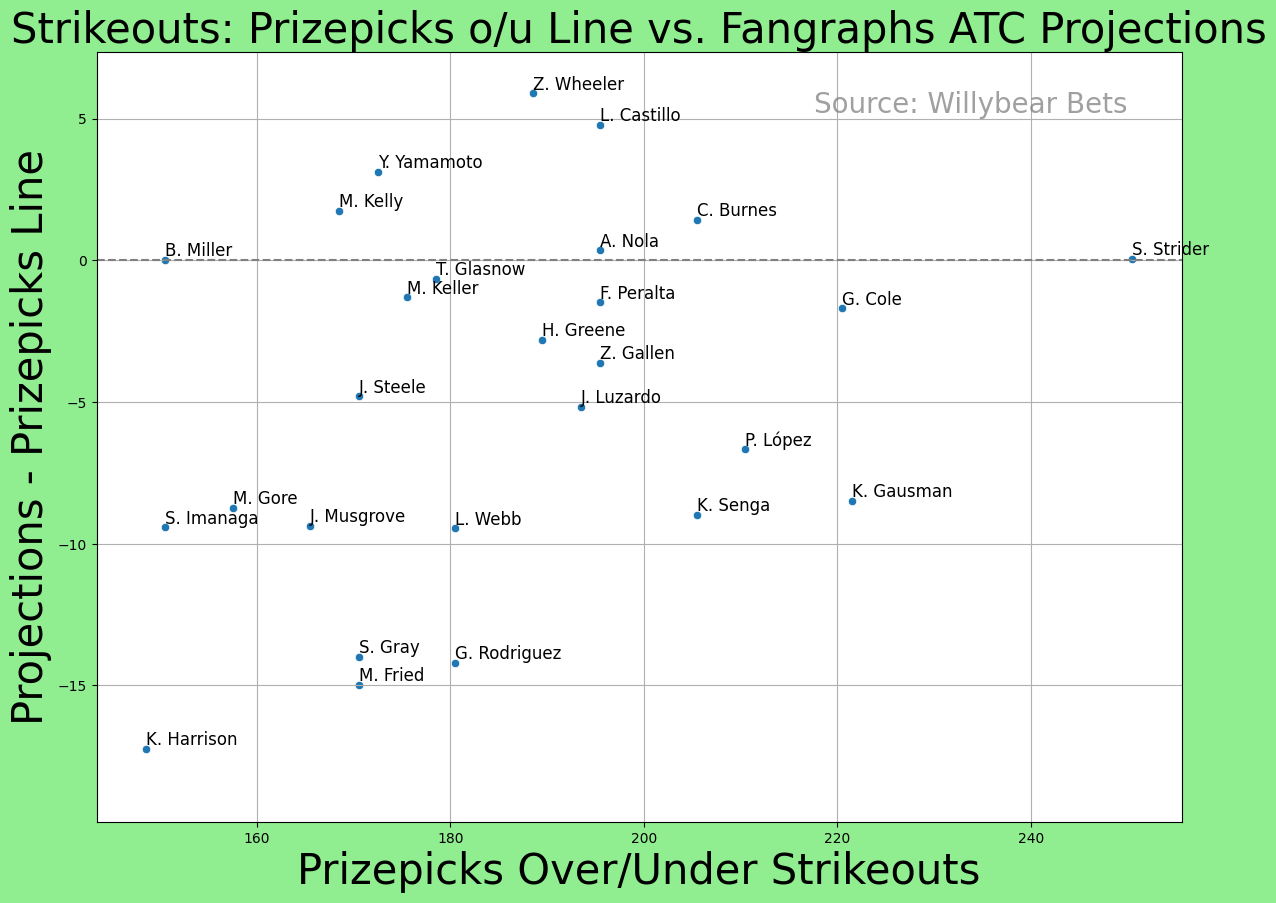

In [153]:
stat = 'Strikeout'
stat_col = "SO_diff"
stat_col_proj = "Strikeouts"

pitch_2_filtered = pitch_2.dropna(subset=[stat_col, stat_col_proj])
# Adjusting the plot to be horizontal for better visualization of differentials
plt.figure(figsize=(14, 10), facecolor='lightgreen')
sns.scatterplot(data=pitch_2_filtered, y=stat_col, x=stat_col_proj)
plt.title(f"{stat}s: Prizepicks o/u Line vs. Fangraphs ATC Projections", fontsize = 30)
plt.ylabel("Projections - Prizepicks Line", fontsize = 30)
plt.xlabel(f"Prizepicks Over/Under {stat}s", fontsize = 30)
plt.ylim(min(pitch_2_filtered[stat_col]) + (min(pitch_2_filtered[stat_col]) * .15),
         max(pitch_2_filtered[stat_col]) + (max(pitch_2_filtered[stat_col]) * .25))
plt.axhline(0, color='grey', ls='--')  # Adding a horizontal reference line at y=0
plt.grid(True)
plt.text(0.95, 0.95, "Source: Willybear Bets", transform=plt.gca().transAxes,
         ha='right', va='top', fontsize=20, color='gray', alpha=0.75)

for index, row in pitch_2_filtered.iterrows():
    # Convert to float before adding the offset
    x_position = (row[stat_col_proj])
    y_position = (row[stat_col])
    plt.text(x_position, y_position, row['Shortened_Name'], verticalalignment='bottom', size='large', color='black')

plt.show()